# 机器学习练习 5 - 偏差和方差

本章代码涵盖了基于Python的解决方案，用于Coursera机器学习课程的第五个编程练习。 请参考[练习文本](ex5.pdf)了解详细的说明和公式。

In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data():
    """
    for ex5
    d['X'] shape = (12, 1)
    pandas has trouble taking this 2d ndarray to construct a dataframe, so I ravel
    the results
    """
    d = sio.loadmat("ex5data1.mat")
    return map(np.ravel, [d["X"], d["y"], d["Xval"], d["yval"], d["Xtest"], d["ytest"]])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data()

/root/miniconda3/envs/lanqiao-ai-py38/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


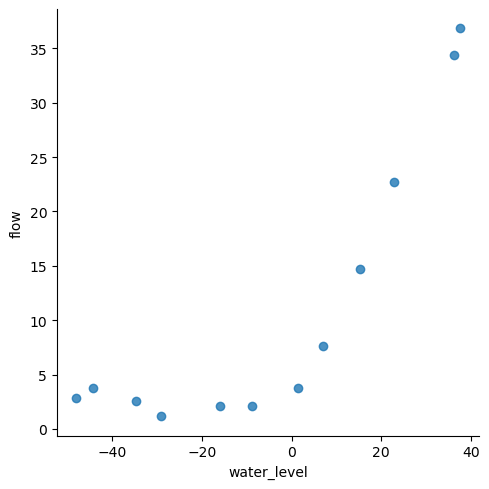

In [11]:
df = pd.DataFrame({"water_level": X, "flow": y})

sns.lmplot(x="water_level", y="flow", data=df, fit_reg=False)
plt.show()

In [16]:
X, Xval, Xtest = [
    np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1)
    for x in (X, Xval, Xtest)
]
# x.reshape(x.shape[0], 1)：首先将数组x重塑为列向量，形状变为(n, 1)，其中n是数组的原始长度。这样做是为了方便后续操作，确保可以作为矩阵处理。
# np.ones(x.shape[0])：生成一个与重塑后数组相同长度的一维数组，所有元素均为1。这将用作截距项。
# np.insert(..., 0, ..., axis=1)：在重塑后的数组的第0个位置（即最左边的列）插入上述生成的全1数组，axis=1表示沿着列方向插入。

# 代价函数
<img style="float: left;" src="../img/linear_cost.png">

In [17]:
def cost(theta, X, y):
    """
    X: R(m*n), m records, n features
    y: R(m)
    theta : R(n), linear regression parameters
    """
    m = X.shape[0]

    inner = X @ theta - y  # R(m*1)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [18]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

# 梯度
<img style="float: left;" src="../img/linear_gradient.png">

梯度下降算法的目标是找到损失函数关于参数的梯度（偏导数），并沿着负梯度方向更新参数以最小化损失函数。在线性回归问题中，我们通常使用的损失函数是均方误差（Mean Squared Error, MSE）。对于线性回归模型 $y = X\theta + \epsilon$，其中 $X$ 是设计矩阵，$\theta$ 是模型参数向量，$y$ 是观测值向量，MSE损失函数可表示为：

$$ L(\theta) = \frac{1}{2m} ||X\theta - y||^2_2 $$

这里 $m$ 是样本数量，$||\cdot||^2_2$ 表示向量的欧几里得范数的平方。

对于MSE损失函数，$\theta$ 的梯度（偏导数向量）可以通过以下步骤推导并简化为矩阵运算形式：

展开损失函数：根据向量和矩阵的运算规则，损失函数关于 $\theta$ 的梯度可以先对 $L(\theta)$ 求导。

求导：对上式关于 $\theta$ 求导得到梯度向量，利用链式法则和矩阵微分的知识，有：

$$ \nabla_{\theta} L(\theta) = \frac{1}{m} X^T(X\theta - y) $$

这里的 $\nabla_{\theta}$ 表示关于 $\theta$ 的梯度算子。

矩阵运算形式：上述梯度表达式可以进一步简化为矩阵乘法的形式，即：
$$ \text{梯度} = \frac{1}{m} X^T(X\theta - y) $$

其中：

$X.T @ (X @ theta - y)$：首先计算模型预测值 $X\theta$ 与实际值 $y$ 的差 $X\theta - y$，得到一个形状为 $m \times 1$ 的向量，然后将其与 $X$ 的转置 $X^T$ 相乘。这个操作实际上就是按照梯度的数学公式进行的计算，其中 $@$ 代表矩阵乘法。
inner / m：最后，将上述结果除以样本数量(m)，以得到平均梯度，这是梯度下降中常用的批量梯度下降法的一步。
因此，通过矩阵运算形式来表达梯度下降的更新步骤，不仅在数学上简洁明了，而且在计算上可以利用现代计算库（如NumPy）高效地处理大规模数据集。

In [19]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)

    return inner / m

In [20]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

# 正则化梯度
<img style="float: left;" src="../img/linear_reg_gradient.png">

In [21]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta

    regularized_term = (l / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [22]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

# 拟合数据
> 正则化项 $\lambda=0$

In [23]:
def linear_regression_np(X, y, l=1):
    """
    linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.ones(X.shape[1])

    # train it
    res = opt.minimize(
        fun=regularized_cost,
        x0=theta,
        args=(X, y, l),
        method="TNC",
        jac=regularized_gradient,
        options={"disp": True},
    )
    return res

In [24]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [25]:
theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get("x")

  NIT   NF   F                       GTG
    0    1  3.039515255535976E+02   3.58038434E+05
tnc: fscale = 0.000835613
    1    3  9.299577620594808E+01   1.36988336E+02
tnc: fscale = 0.0427197
    2    5  4.008652229372914E+01   2.25223359E+04
    3    7  2.237390649510893E+01   7.22600088E-12
tnc: fscale = 186003
tnc: |fn-fn-1] = 5.00702e-15 -> convergence
    4    9  2.237390649510892E+01   2.33316340E-14
tnc: Converged (|f_n-f_(n-1)| ~= 0)


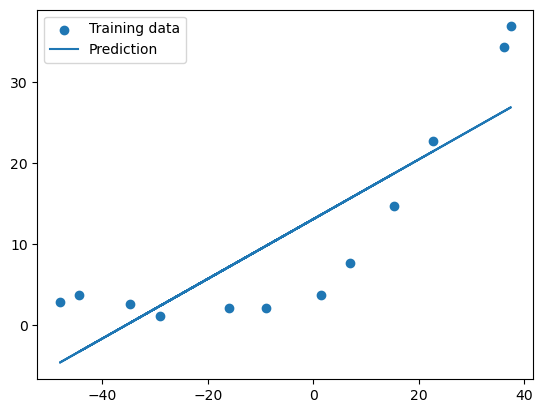

In [26]:
b = final_theta[0]  # intercept
# final_theta通常是梯度下降或最小二乘法等线性回归算法的输出，包含模型的参数，第一个元素通常是截距项。

m = final_theta[1]  # slope
# 从final_theta数组中取出第二个元素作为斜率（slope）

plt.scatter(X[:, 1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1] * m + b, label="Prediction")
# X[:, 1] * m + b计算的是每个样本点的预测值，即X的每个样本的特征值乘以斜率m再加上截距b。

plt.legend(loc=2)
plt.show()

In [27]:
training_cost, cv_cost = [], []

1.使用训练集的子集来拟合模型

2.在计算训练代价和交叉验证代价时，没有用正则化

3.记住使用相同的训练集子集来计算训练代价

In [28]:
m = X.shape[0]
for i in range(1, m + 1):
    #     print('i={}'.format(i))
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    # 对前i个样本进行线性回归，使用linear_regression_np函数

    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    # 训练成本（training cost）
    # 计算使用前i个样本训练的模型在训练集上的成本，res.x是模型参数，X[:i, :]和y[:i]是对应的训练数据，l=0表示不使用正则化。
    
    cv = regularized_cost(res.x, Xval, yval, l=0)
    # 交叉验证成本（cross-validation cost）
    # # 计算模型在交叉验证集Xval和yval上的成本，同样不使用正则化。
    
    #     print('tc={}, cv={}'.format(tc, cv))

    training_cost.append(tc)
    cv_cost.append(cv)

  NIT   NF   F                       GTG
    0    1  1.457106922645887E+02   7.43067003E+04
tnc: fscale = 0.00183424
    1    3  8.631534185484672E-18   4.40174166E-15
tnc: |pg| = 3.61706e-05 -> local minimum
    1    3  8.631534185484672E-18   4.40174166E-15
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  2.878623740891748E+02   3.18073041E+05
tnc: fscale = 0.000886557
    1    3  2.004821342908418E-01   3.16698305E-02
tnc: fscale = 2.80962
    2    5  1.406351957431711E-04   1.55393840E-01
    3    7  1.198297373799073E-17   1.11887202E-17
tnc: |pg| = 1.19054e-09 -> local minimum
    3    7  1.198297373799073E-17   1.11887202E-17
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  1.932434806358119E+02   1.68157035E+05
tnc: fscale = 0.00121931
    1    3  8.863206576484284E+01   1.68991145E+02
tnc: fscale = 0.0384625
    2    5  4.163141390502957E+01   3.39442373E+04
    3    7  3.286595045501271E+00   1.93

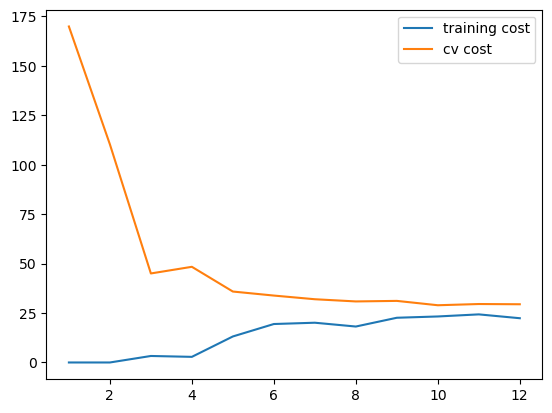

In [29]:
plt.plot(np.arange(1, m + 1), training_cost, label="training cost")
plt.plot(np.arange(1, m + 1), cv_cost, label="cv cost")
plt.legend(loc=1)
plt.show()

这个模型拟合不太好, **欠拟合了**

# 创建多项式特征

In [36]:
# 对输入的数据集（如训练集X、验证集Xval、测试集Xtest）进行多项式特征扩展、归一化处理，并添加截距项
def prepare_poly_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    # power: 指定多项式特征扩展的最大次数，例如，如果power=2，则会生成包括原始特征、特征的平方在内的多项式特征。

    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)
        # 将输入数据集x转换为多项式特征，例如，如果x是一个一维数组，则可能返回包含x, x^2, x^3, ...直到指定的power次幂的特征）。

        # normalization
        ndarr = normalize_feature(df)
        # 对生成的多项式特征数据框df应用归一化处理，以消除特征尺度差异，提高模型训练效率。

        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [31]:
def poly_features(x, power, as_ndarray=False):
    # as_ndarray: 布尔值，默认为False。如果设为True，函数将返回一个NumPy数组；如果为False，则返回一个Pandas DataFrame。
    
    data = {"f{}".format(i): np.power(x, i) for i in range(1, power + 1)}
    # 这部分使用字典推导式生成了一个字典，其中键是特征名称（如f1, f2, ...），值是对应次数的多项式特征。np.power(x, i)计算x的i次幂，range(1, power + 1)涵盖了从1到power的所有整数。
    
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df

In [32]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [33]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


# 准备多项式回归数据
1. 扩展特征到 8阶,或者你需要的阶数
2. 使用 **归一化** 来合并 $x^n$ 
3. don't forget intercept term

In [34]:
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [37]:
X_poly, Xval_poly, Xtest_poly = prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

# 画出学习曲线
> 首先，我们没有使用正则化，所以 $\lambda=0$

In [38]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        res = linear_regression_np(X[:i, :], y[:i], l=l)

        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label="training cost")
    plt.plot(np.arange(1, m + 1), cv_cost, label="cv cost")
    plt.legend(loc=1)

  NIT   NF   F                       GTG
    0    1  5.196208292205368E+00   3.17343613E+01
    1    3  5.957617062581990E-18   3.63844484E-17
tnc: |pg| = 6.03195e-09 -> local minimum
    1    3  5.957617062581990E-18   3.63844484E-17
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  3.686037992896324E+00   1.74005107E+01
    1    4  1.002785554404476E-16   5.57091869E-17
tnc: |pg| = 7.46386e-09 -> local minimum
    1    4  1.002785554404476E-16   5.57091869E-17
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  1.364046313185939E+02   5.94961274E+02
tnc: fscale = 0.0204987
    1    4  6.000560570760940E-01   2.63211082E-01
tnc: fscale = 0.974581
    2    8  3.623880468901172E-16   1.48363118E-15
tnc: |pg| = 3.95226e-08 -> local minimum
    2    8  3.623880468901172E-16   1.48363118E-15
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  2.141362053785440E+02   1.49259859E+

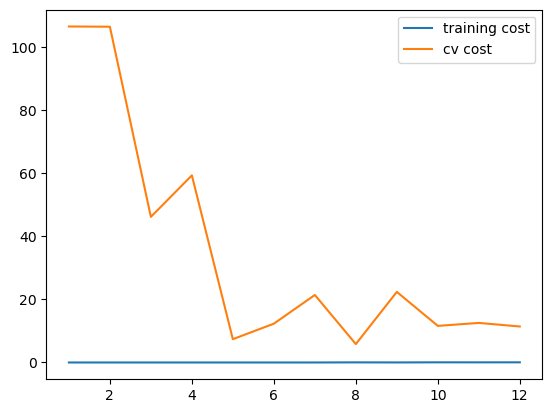

In [39]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

你可以看到训练的代价太低了，不真实. 这是 **过拟合**了

try $\lambda=1$

  NIT   NF   F                       GTG
    0    1  9.196208292205368E+00   5.32057794E+01
    1    4  7.266489238927185E-03   3.84114407E-03
    2    7  7.439856461517544E-05   1.90689940E-04
tnc: fscale = 36.2081
    3   11  1.716115504526867E-19   1.22104855E-18
tnc: |pg| = 3.05183e-11 -> local minimum
    3   11  1.716115504526867E-19   1.22104855E-18
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  5.686037992896324E+00   2.47635192E+01
    1    4  8.395887478235500E-02   4.75161003E-03
    2    8  7.270184481777571E-02   7.52952441E-06
tnc: fscale = 182.216
    3   11  7.269436294582277E-02   1.86033900E-08
tnc: fscale = 3665.84
tnc: |fn-fn-1] = 7.41927e-09 -> convergence
    4   15  7.269435552655627E-02   1.44403481E-12
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1  1.377379646519273E+02   5.66672779E+02
tnc: fscale = 0.0210041
    1    4  1.939519494524498E+01   1.40114548E+00
tnc: fscale = 0.42

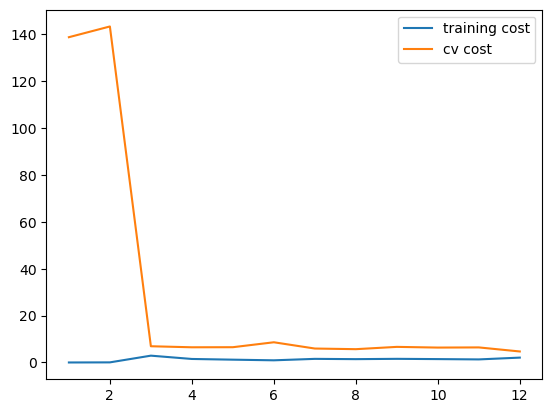

In [40]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()


训练代价增加了些，不再是0了。
也就是说我们减轻**过拟合**

# try $\lambda=100$

  NIT   NF   F                       GTG
    0    1  4.051962082922054E+02   8.13788762E+04
tnc: fscale = 0.00175273
    1    4  5.832091070216597E-01   1.33251834E+00
tnc: fscale = 0.433145
    2    8  8.624199290958889E-18   1.72647670E-15
tnc: |pg| = 9.59283e-08 -> local minimum
    2    8  8.624199290958889E-18   1.72647670E-15
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  2.036860379928963E+02   2.05537014E+04
tnc: fscale = 0.00348759
    1    4  2.831008435195471E-01   3.56301816E-01
tnc: fscale = 0.837647
    2    8  1.147779356625165E-01   8.55452076E-09
tnc: fscale = 5405.95
tnc: |fn-fn-1] = 8.51075e-11 -> convergence
    3   11  1.147779355774090E-01   1.39407819E-18
tnc: Converged (|f_n-f_(n-1)| ~= 0)
  NIT   NF   F                       GTG
    0    1  2.697379646519273E+02   6.56611179E+03
tnc: fscale = 0.00617044
    1    4  1.433800297634809E+02   9.90613232E+02
    2    7  1.127877217926490E+02   3.29529026E-01
tnc: fscale = 0.

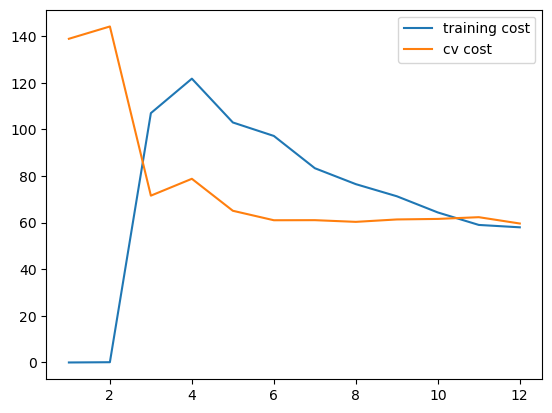

In [41]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

太多正则化了.  
变成 **欠拟合**状态

# 找到最佳的 $\lambda$

In [42]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [43]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)

    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)

    training_cost.append(tc)
    cv_cost.append(cv)

  NIT   NF   F                       GTG
    0    1  1.046321620777136E+02   3.09396153E+02
tnc: fscale = 0.0284258
    1    5  2.059431577535798E+00   5.93767173E-01
tnc: fscale = 0.648876
    2    9  1.014270072780564E+00   1.15753293E+00
    3   13  4.292592353278491E-01   2.15381971E-03
    4   18  2.423123443328357E-01   5.26892223E-05
tnc: fscale = 68.8825
    5   23  1.995094383775619E-01   1.53358771E-04
    6   28  1.899389712137332E-01   5.37046968E-03
    7   33  1.775234991576528E-01   3.58369971E-05
    8   38  1.543345639499988E-01   3.16110750E-02
tnc: fscale = 2.81223
    9   41  1.380552844790338E-01   3.30573363E-03
   10   46  1.347083145454173E-01   4.99744358E-05
tnc: fscale = 70.7288
   11   49  1.338726689870445E-01   7.11322469E-04
   12   54  1.330119254965202E-01   9.74892946E-05
   13   59  1.271933186756597E-01   6.63658450E-05
   14   64  1.071388670490296E-01   3.66765046E-03
   15   67  1.051302148195148E-01   7.76420621E-05
   16   71  1.049310584291553E

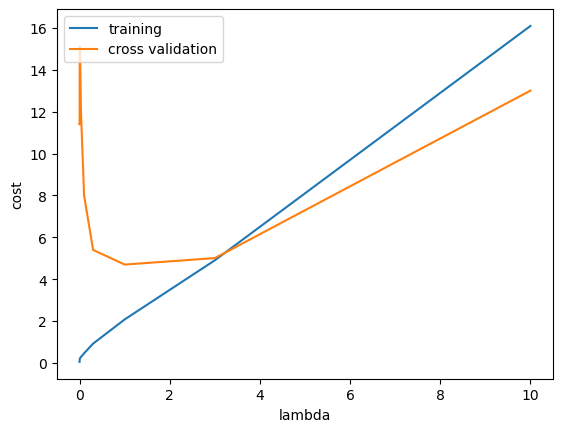

In [44]:
plt.plot(l_candidate, training_cost, label="training")
plt.plot(l_candidate, cv_cost, label="cross validation")
plt.legend(loc=2)

plt.xlabel("lambda")

plt.ylabel("cost")
plt.show()

In [45]:
# best cv I got from all those candidates
l_candidate[np.argmin(cv_cost)]

1

In [46]:
# use test data to compute the cost
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print("test cost(l={}) = {}".format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 10.036017031138007
test cost(l=0.001) = 11.099315407544127
test cost(l=0.003) = 11.285151243584265
test cost(l=0.01) = 10.880540840462944
test cost(l=0.03) = 10.022338896121171
test cost(l=0.1) = 8.632065034569443
test cost(l=0.3) = 7.336510194131264
test cost(l=1) = 7.466312450972246
test cost(l=3) = 11.64403544533935
test cost(l=10) = 27.715080285803165


  NIT   NF   F                       GTG
    0    1  1.046321620777136E+02   3.09396153E+02
tnc: fscale = 0.0284258
    1    5  2.059431577535798E+00   5.93767173E-01
tnc: fscale = 0.648876
    2    9  1.014270072780564E+00   1.15753293E+00
    3   13  4.292592353278491E-01   2.15381971E-03
    4   18  2.423123443328357E-01   5.26892223E-05
tnc: fscale = 68.8825
    5   23  1.995094383775619E-01   1.53358771E-04
    6   28  1.899389712137332E-01   5.37046968E-03
    7   33  1.775234991576528E-01   3.58369971E-05
    8   38  1.543345639499988E-01   3.16110750E-02
tnc: fscale = 2.81223
    9   41  1.380552844790338E-01   3.30573363E-03
   10   46  1.347083145454173E-01   4.99744358E-05
tnc: fscale = 70.7288
   11   49  1.338726689870445E-01   7.11322469E-04
   12   54  1.330119254965202E-01   9.74892946E-05
   13   59  1.271933186756597E-01   6.63658450E-05
   14   64  1.071388670490296E-01   3.66765046E-03
   15   67  1.051302148195148E-01   7.76420621E-05
   16   71  1.049310584291553E

调参后， $\lambda = 0.3$ 是最优选择，这个时候测试代价最小